# Import libraries, Load Data

In [1]:
#from google.colab import drive
#drive.mount('/content/drive')
#comment

In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.statespace.sarimax import SARIMAX
import seaborn as sns
import yfinance as yf
from numpy import linalg as LA
from sklearn.cluster import KMeans
from statsmodels.tsa.stattools import coint
from itertools import combinations

In [3]:
price_path = '/Users/tuckeringlefield/Desktop/FinanceData/price_data_from_shardar.csv'
cap_path = '/Users/tuckeringlefield/Desktop/FinanceData/cap_data_from_shardar.csv'
prices_df = pd.read_csv(price_path, index_col='date')
caps_df = pd.read_csv(cap_path, index_col='date')

In [4]:
# Convert dates to datetime
prices_df.index = pd.to_datetime(prices_df.index)

# Get the initial start and end date
start_date = prices_df.index[0]
end_date = prices_df.index[89]

spy_data = yf.download('SPY', start=start_date, end=end_date, interval='1d')
spy_data = pd.DataFrame(spy_data["Adj Close"])
spy_data.rename({"Adj Close": 'SPY'}, inplace=True, axis=1)
spy_data = spy_data.reindex(prices_df.index)
prices_with_market = pd.concat([prices_df, spy_data], axis=1)

df_diff = prices_with_market.diff().dropna()

[*********************100%%**********************]  1 of 1 completed


In [5]:
print(len(prices_with_market))
print(len(df_diff))

5787
0


# Outline and Function Definitions

Outline:

We want to start from the year 2000 and do our analysis in two periods:

- Learning Period

This will require 3 months of data. The top ten largest market cap stocks will be calculated. We should check for null values, this will let us know what stocks were recently added. We can then remove/add stocks by relevency. We then should calculate the correlation matrix for these stocks off of the last day of the three months. Then we will do k means clustering to find pairs that are cointegrated based of off the ADF.

- Testing Period

This will operate on two weeks of data. We will look at the spread between the stocks. If the spread goes more than 2 std deviations away from the mean for the correlation matrix period we will suggest opening a trade. Spread will come from the linear regression coefficient.

### Functions

In [6]:
# Function to find the top ten largest market cap stocks
def find_top_ten(dataframe, date_start, date_end):
    # Filter dataframe over the desired 3 months
    filtered_data = dataframe.loc[date_start:date_end]
    end_date_dt = pd.to_datetime(date_end)
    target_date = (end_date_dt + pd.DateOffset(1)).date().strftime('%Y-%m-%d')
    selected_row = caps_df.loc[target_date]
    selected_row_no_null = selected_row.dropna()
    stocks_list = selected_row_no_null.nlargest(10).index.tolist()
    return stocks_list

In [7]:
# Function to check for null values
def check_top_ten(dataframe, date_start, date_end, stocks_list):
    #should find the average and median ammount of null values per column
    #print this out and print out top ten col's ammounts
    ammount_null = []
    for column in df.columns:
        num_null = df[column].isnull().sum()
        ammount_null.append(num_null)
    average_num_null = np.mean(ammount_null)
    median_num_null = np.median(ammount_null)
    plt.boxplot(ammount_null, vert=False)
    plt.title('Boxplot of null values per stock in time period')
    plt.show()
    print("Checking Stocks List")
    print("--------------------")
    for column in stocks_list:
        num_null = df[column].isnull().sum()
        print(f'Stock: {column}, Num null: {num_null}')

In [8]:
# Function to filter the DF
def filter_diff_df(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end].diff().dropna()
    return filtered_df

In [9]:
def filter_df_by_dates(dataframe, date_start, date_end, stocks_list):
    desired_columns = stocks_list.copy()
    desired_columns.append("SPY")
    print(desired_columns)
    filtered_df = dataframe[desired_columns]
    filtered_df = filtered_df[date_start:date_end]
    return filtered_df

In [10]:
# Function to calculate the betas
def calculate_betas(dataframe, date_start, date_end, stocks_list):
    df = dataframe[(dataframe.index >= date_start) & (dataframe.index <= date_end)]
    beta_values = []
    columns = []

    df_var = df['SPY'].var()

    for stk in stocks_list:
        df_cov = df[[stk, 'SPY']].cov().loc[stk, 'SPY']
        beta = df_cov / df_var
        beta_values.append(beta)
        columns.append(stk + '_beta')

    beta_df = pd.DataFrame([beta_values], columns=columns)
    beta_df.index = df.index[:1]

    plt.figure(figsize=(12, 4))
    sns.boxplot(data=beta_df)
    plt.show()

    return beta_df

In [11]:
# Function to calculate the residuals
def calculate_residuals(df, stocks_list):
    res_df = pd.DataFrame()
    for stk in stocks_list:
        res_df[stk] = df[stk]-df[stk+"_beta"]*df["SPY"]
    return res_df

In [12]:
# Function to cluster the matrix
def cluster_the_matrix(df, num_clusters):
    A = abs(df.corr().values)
    print(f'A Shape: {A.shape}')
    D = np.diag(A.sum(axis=1))
    print(f'D Shape: {D.shape}')
    L = D - A
    print(f'L Shape: {L.shape}')
    eigenvalues, eigenvectors = LA.eig(L)
    X = eigenvectors[:,:num_clusters]
    print(f'X Shape: {X.shape}')
    kmeans = KMeans(n_clusters=num_clusters, random_state=2, n_init=20).fit(X)
    print("Kmeans Labels:")
    print(kmeans.labels_)
    print(df.columns)

    cluster_dict = {}

    # Iterate over the indices of cluster_list
    for i in range(len(kmeans.labels_)):
        cluster_number = kmeans.labels_[i]
        stock_name = df.columns[i]

        # Check if cluster_number is already a key in the dictionary
        if cluster_number in cluster_dict:
            cluster_dict[cluster_number].append(stock_name)
        else:
            cluster_dict[cluster_number] = [stock_name]

    fig, ax = plt.subplots(1, 1, figsize=(8, 4))
    scatter = ax.scatter(X[:, 0], X[:, 1], c=kmeans.labels_)
    unique_labels = {label: idx for idx, label in enumerate(set(kmeans.labels_))}
    handles = [plt.Line2D([0], [0], marker='o', color='w', markerfacecolor=scatter.cmap(scatter.norm(value)), markersize=10)
           for value in unique_labels.values()]
    labels = unique_labels.keys()
    ax.legend(handles, labels, title="Clusters", loc="best", bbox_to_anchor=(1, 1))
    ax.set_title(f'K-Means Clustering Results with K={num_clusters}')
    plt.show()

    return cluster_dict


In [13]:
# Function to find the cointegrated pairs
def find_cointegrated_pairs(dataframe, cluster_dict, sig_level):
    cointegrated_pairs = []
    for cluster_num, stocks in cluster_dict.items():
      for stock1, stock2 in combinations(stocks, 2):
          pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
          pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
          if pvalue1 < sig_level and pvalue2 < sig_level:
              cointegrated_pairs.append([stock1, stock2])
    return cointegrated_pairs

In [26]:
# Function to check on existing pairs
def is_still_conintegrated(dataframe, start_date, end_date, pair, sig_level):
    stock1 = pair[0]
    stock2 = pair[1]
    pvalue1 = coint(dataframe[stock1], dataframe[stock2])[1]
    pvalue2 = coint(dataframe[stock2], dataframe[stock1])[1]
    if pvalue1 < sig_level and pvalue2 < sig_level:
        return True
    return False

In [14]:
# Monitor a pair for a week
def monitor_pair_for_week(dataframe, pair, start_date, pair_vals_list):
    #[ still_consecutive, [start_dates], [end_date], times_correct, weeks_counted, curr_accuracy, [accuracy] ]

    # Verify if the stock is still cointegrated
    end_date = ''
    is_coint = is_still_conintegrated(dataframe, start_date, end_date, pair , sig_level=0.05)
    if is_coint:
        #Accuracy Stuff
        # if (is accurate):
            #pair_vals_list[3] +=1
        pair_vals_list[4] +=1
        pass
    else:
    #   pair_vals_list[0] = False
    #   pair_vals_list[2].append(end_date)
    #   pair_vals_list[6].append( pair_vals_list[3] / pair_vals_list[4] )
    #   pair_vals_list[3] = 0
    #   pair_vals_list[4] = 0
        pass
    return pair_vals_list

In [15]:
def monitor_group_of_pairs(dataframe, pair_dict, stop_after_weeks):
    coint_dict = pair_dict.copy()
    weeks_running = 0
    while(weeks_running < stop_after_weeks):
        # On the first week we don't have any previous data in the pair_dict What do we pass in??? 
        training_and_monitoring_start_date = dataframe.index[((weeks_running+1)*7)]
        for key, value in coint_dict.items():
            # end_date = start_date + WEEK            
            result = monitor_pair_for_week(dataframe, key, training_and_monitoring_start_date, value)
            # Update pair_dict[pair] with result
            pair_dict[key] = result
        # Prepping for the next week...
        # Train by adding the new data in
        # Call our trading functions
        # Update cointegrated pairs list
        weeks_running += 1
    return pair_dict

In [16]:
# What data should we consider for cointegrated pairs
# Consecutivity?
# Pair1 was consecutive from April 3rd 1992 - March 5th 2002 with ___ acuracy from training model.
# Pair1 was consecutive from May 4th 2002- Aug 27th 2002 with __ acuracy from training model.
# How do we design the data structure for both of these statements
#
# Accuracy? Threshold? Specific hypothesis test for accuary of forcasting
# Visualizations?
# Probably not a great idea to itterate over
# Line charts after we get printout
# Limit the output based on accuracy?

# Pair dict output:
# intl and oracle are the two stocks. if we end up monitoring them twice? will the second time override the first time in the dictionary?



In [17]:
# TO DO:

# 1) Find out what we want to output...
# Pair1 was consecutive from April 3rd 1992 - March 5th 2002 with ___ acuracy from training model.
# Pair1 was consecutive from May 4th 2002- Aug 27th 2002 with __ acuracy from training model.
# What do we need to make this sentence
# Key : tuple (stock1, stock2)
# Value : List
# [ still_consecutive, [start_dates], [end_date], times_correct, weeks_counted, curr_accuracy, [accuracy] ]
# end output
# start date ['Jan 2000', 'Oct 2002', 'Dec 2003']
# end date ['march 2000', 'feb 2003', 'may 2004']
# accuracy [0.65, 0.74, 0.57]


# 2) Find out data structure supports this...
# 3) How does this impliment into our two functions...

# Testing Functions

In [18]:
prices_with_market.head()

,ATW,A,AA,AAAB,AABC,AAC1,AACC,AACE,AACH,AADI,...,ZVOI,ZVRA,ZVUE,ZVXI,ZY,ZYME,ZYNE,ZYXI,ZZ,SPY
date,,,,,,,,,,,,,,,,,,,,,
2000-01-03,8.766,44.275,NaN,8.036,7.791,4.562,NaN,17.000,NaN,NaN,...,NaN,NaN,NaN,3.625,NaN,NaN,NaN,NaN,NaN,93.290138
2000-01-04,8.913,40.893,NaN,7.619,7.791,4.438,NaN,15.875,NaN,NaN,...,NaN,NaN,NaN,3.500,NaN,NaN,NaN,NaN,NaN,89.641945
2000-01-05,8.899,37.855,NaN,7.500,7.791,4.438,NaN,16.125,NaN,NaN,...,NaN,NaN,NaN,3.708,NaN,NaN,NaN,NaN,NaN,89.802315
2000-01-06,9.270,36.896,NaN,7.500,7.791,4.500,NaN,16.125,NaN,NaN,...,NaN,NaN,NaN,3.833,NaN,NaN,NaN,NaN,NaN,88.359070
2000-01-07,9.508,39.971,NaN,7.738,7.607,4.562,NaN,16.750,NaN,NaN,...,NaN,NaN,NaN,4.167,NaN,NaN,NaN,NaN,NaN,93.490555


In [19]:
start = prices_with_market.index[0]
end = prices_with_market.index[89]
top_ten = find_top_ten(prices_with_market, start, end)
print(top_ten)
# check_top_ten(df, start, end, top_ten)
# print()

['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM']


In [20]:
filtered_diff_df = filter_diff_df(prices_with_market, start, end, top_ten)
filtered_diff_df.head()
three_month_top_10_price_df = filter_df_by_dates(prices_with_market, start, end, top_ten)

['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM', 'SPY']
['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1', 'MSFT', 'QCOM', 'SPY']


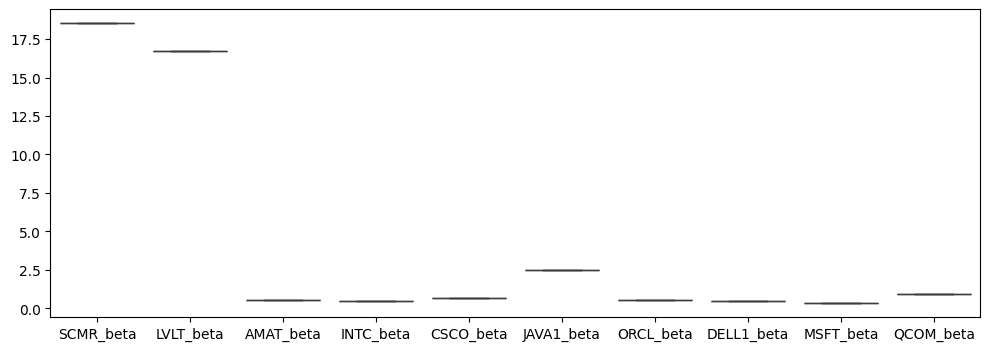

Beta DF:
            SCMR_beta  LVLT_beta  AMAT_beta  INTC_beta  CSCO_beta  JAVA1_beta  \
date                                                                            
2000-01-04  18.534952    16.6978   0.505718   0.475473   0.684216    2.472622   

            ORCL_beta  DELL1_beta  MSFT_beta  QCOM_beta  
date                                                     
2000-01-04   0.508757    0.451128   0.329187   0.901153  

Residual DF:
          SCMR       LVLT      AMAT      INTC      CSCO      JAVA1      ORCL  \
0    18.035088 -27.133199  0.701956  0.566617  0.393151  -0.479398 -0.275955   
1   -38.805448 -36.427824 -1.021102  0.409748  0.166272  -0.146534 -0.942589   
2   -69.082525 -22.850985  0.858874 -1.005776  0.022491  -4.181401 -0.802739   
3    13.221173 -54.634508 -2.411082 -1.504882 -1.477043  -4.938221 -1.093680   
4     9.053549  55.542951  1.589754  0.927457  1.124487  12.831724  2.377779   
..         ...        ...       ...       ...       ...        ...       ...   

In [21]:
beta_df = calculate_betas(filtered_diff_df, start, end, top_ten)
print('Beta DF:')
print(beta_df)
print()

merged_df = filtered_diff_df.merge(beta_df, how = 'cross')

print('Residual DF:')
res_df = calculate_residuals(merged_df, top_ten)
print(res_df)

A Shape: (10, 10)
D Shape: (10, 10)
L Shape: (10, 10)
X Shape: (10, 4)
Kmeans Labels:
[1 1 2 1 0 3 1 1 1 1]
Index(['SCMR', 'LVLT', 'AMAT', 'INTC', 'CSCO', 'JAVA1', 'ORCL', 'DELL1',
       'MSFT', 'QCOM'],
      dtype='object')


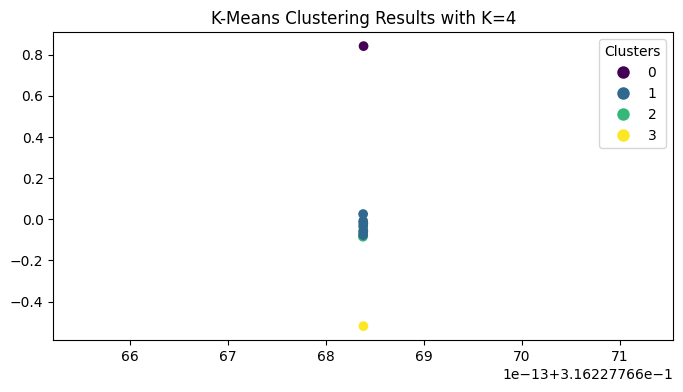

In [22]:
cluster_dictionary_for_top_10 = cluster_the_matrix(res_df, 4)

In [23]:
coint_pairs_from_top_10 = find_cointegrated_pairs(three_month_top_10_price_df, cluster_dictionary_for_top_10, 0.05)
coint_pairs_from_top_10

[['INTC', 'ORCL']]

In [ ]:
pair_dict = {
        # [ still_consecutive, [start_dates], [end_date], times_correct, weeks_counted, curr_accuracy, [accuracy] ]
        ('INTC', 'ORCL') : [ True, ['2000-01-03'], [], 0, 0, 0, [] ]
    }